In [1]:
import re
import os 
import sys 

import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io

from pathlib import Path
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import scanpy as sc
import squidpy as sq
sc.settings.verbosity = 3

from matplotlib.pyplot import rc_context
from matplotlib import cm, colors
import matplotlib
sc.set_figure_params(format='png')
from PIL import Image
import seaborn as sns 
import anndata as ad


In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

In [6]:
donor = f"combined_raw_09_15_new_mask"

all_donor = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
    "SP Donor A"
]


In [7]:
import spatial as sm

# Import data

In [8]:
adata_path = data_dir / "metadata" / f"{donor}.h5ad"

In [9]:
adata = sc.read_h5ad(adata_path)

In [10]:
markers_list = ['CD38', 'Vimentin', 'CD21', 'BCL6', 'ICOS1', 'CD11c',
       'FoxP3', 'CD4', 'CD138', 'CXCR5', 'CD20', 'CD8',  'PD1',
       'Ki67', 'COL1', 'CD3', 'CD27', 'EZH2', 'H3K27me3']

In [11]:
adata = adata[:, markers_list]

In [29]:
adata.uns['all_markers'] = adata.var_names
adata.obs['X_centroid'] = adata.obsm['spatial'][:,0]
adata.obs['Y_centroid'] = adata.obsm['spatial'][:,1]


# Manual Gating

In [30]:
donor = 'TS DonorA'
img_dir = data_dir / "whole_stitched" / donor

imgs = []
for marker in adata.var_names:
    img = io.imread(img_dir / f'{marker}.tif')
    imgs.append(img)
    
imgs = np.stack(imgs)

save_path = img_dir / f'all.tif'
skimage.io.imsave(save_path, imgs, plugin='tifffile')

In [52]:
# donor = 'TS Donor A'
# marker = 'CD27'
# adata_subset = adata[adata.obs.Dataset == donor]
# sc.pp.scale(adata_subset)

# sm.pl.gate_finder (save_path, adata_subset, marker, 
#                    from_gate = 0.0, to_gate = 1.5, increment = 0.1, markers=[marker],
#                    point_size=6)

# Phenotype 

In [53]:
sc.pp.scale(adata)

In [56]:
manual_gate = pd.read_csv(data_dir / "metadata" / 'manual_gates.csv')
adata = sm.pp.rescale(adata, log=False, imageid='Dataset', gate=manual_gate)

GMM for ['LN Donor A', 'LN Donor E', 'INT Donor B', 'INT Donor E', 'TS Donor A', 'TS Donor E', 'SP Donor A']
Categories (7, object): ['INT Donor B', 'INT Donor E', 'LN Donor A', 'LN Donor E', 'SP Donor A', 'TS Donor A', 'TS Donor E']
Finding the optimal gate by GMM for ICOS1
Finding the optimal gate by GMM for CD11c
Finding the optimal gate by GMM for FoxP3
Finding the optimal gate by GMM for CD138
Finding the optimal gate by GMM for EZH2
Finding the optimal gate by GMM for H3K27me3
Scaling Image LN Donor A
Scaling CD38
Scaling Vimentin
Scaling CD21
Scaling BCL6
Scaling ICOS1
Scaling CD11c
Scaling FoxP3
Scaling CD4
Scaling CD138
Scaling CXCR5
Scaling CD20
Scaling CD8
Scaling PD1
Scaling Ki67
Scaling COL1
Scaling CD3
Scaling CD27
Scaling EZH2
Scaling H3K27me3
Scaling Image LN Donor E
Scaling CD38
Scaling Vimentin
Scaling CD21
Scaling BCL6
Scaling ICOS1
Scaling CD11c
Scaling FoxP3
Scaling CD4
Scaling CD138
Scaling CXCR5
Scaling CD20
Scaling CD8
Scaling PD1
Scaling Ki67
Scaling COL1
Scali

In [57]:
# Load the gating workflow
phenotype= pd.read_csv(data_dir / "metadata" / 'phenotype_workflow.csv')
adata = sm.tl.phenotype_cells (adata, phenotype=phenotype, label="phenotype")

Phenotyping Immune
Phenotyping Stroma 
Phenotyping Follicular dendritic cells
-- Subsetting Immune
Phenotyping T cells
Phenotyping B cells
-- Subsetting T cells
Phenotyping Cytotoxic T cells
Phenotyping Helpter T cells
-- Subsetting B cells
Phenotyping LZ B cells
Phenotyping DZ B cells
Phenotyping Plasma cells
Phenotyping Memory B cells
-- Subsetting Cytotoxic T cells
Phenotyping Follicular CD8+ T cells
Phenotyping Exhausted T cells
-- Subsetting Helpter T cells
Phenotyping Follicular Helper T cells
Phenotyping Regulatory T-cells
Consolidating the phenotypes across all groups


In [58]:
# Summary of the phenotyping
adata.obs['phenotype'].value_counts()

Unknown                       487993
Helpter T cells               291829
Stroma                        270253
LZ B cells                    210564
DZ B cells                    135755
Follicular dendritic cells     92730
Plasma cells                   89047
Cytotoxic T cells              72830
T cells                        69350
Regulatory T-cells             65475
B cells                        56989
Follicular Helper T cells      37029
Memory B cells                 31863
Exhausted T cells              27215
Follicular CD8+ T cells        16528
Name: phenotype, dtype: int64

In [59]:
adata.uns['phenotype_colors'] = sc.pl.palettes.vega_20[:len(np.unique(adata.obs['phenotype']))]
adata.obs['phenotype']  = adata.obs['phenotype'].astype('category')

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_phenotype']`


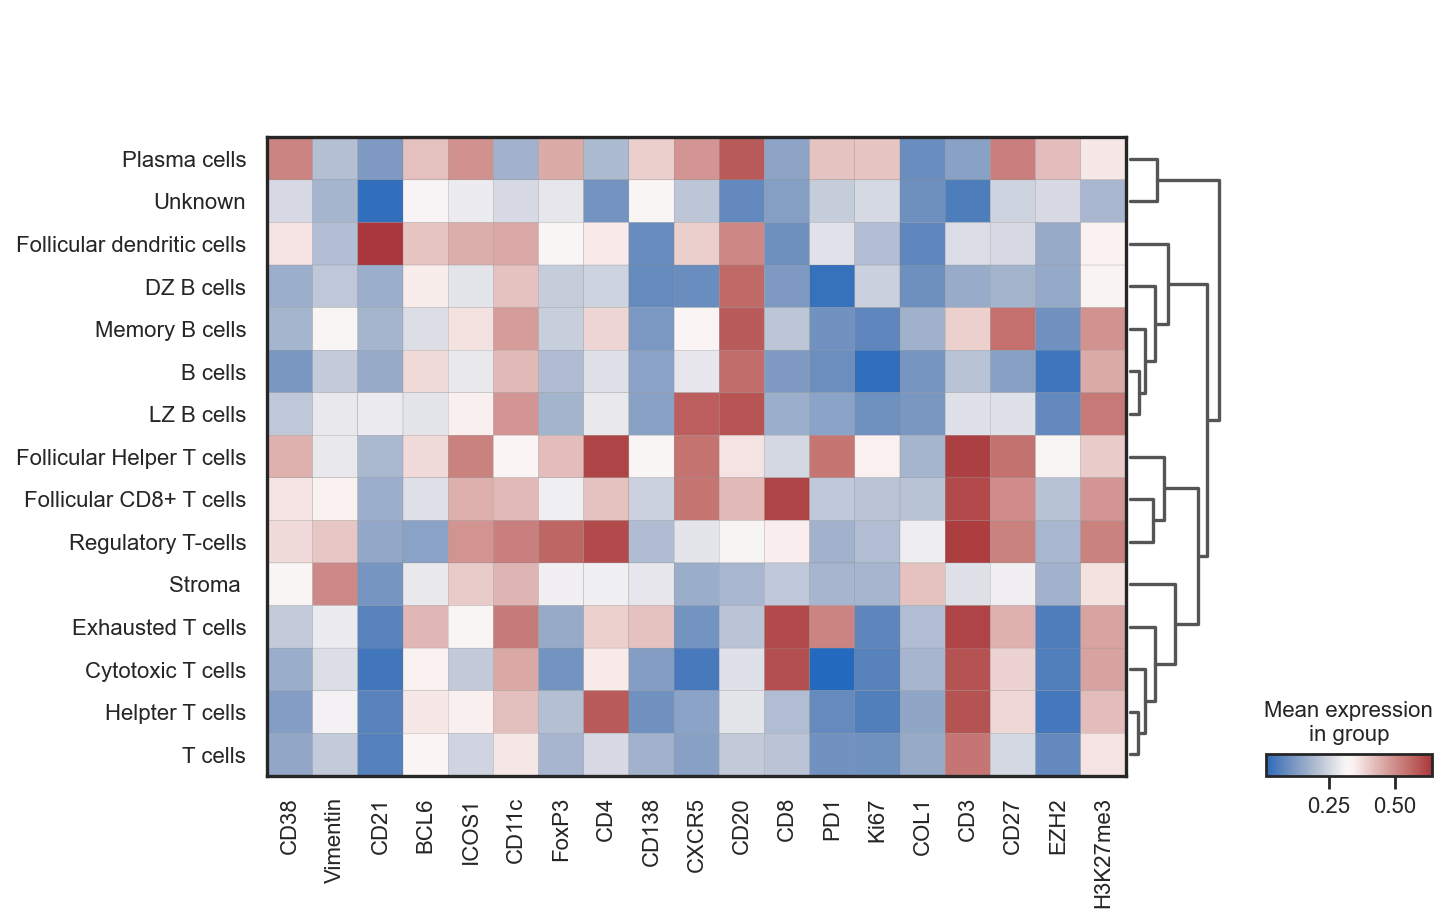

In [60]:
sc.tl.dendrogram(adata, groupby='phenotype')
sc.pl.matrixplot(adata, var_names= adata.var.index, groupby='phenotype', dendrogram=True, use_raw=False, cmap="vlag",)


In [61]:
import matplotlib 

var = 'phenotype'

cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}




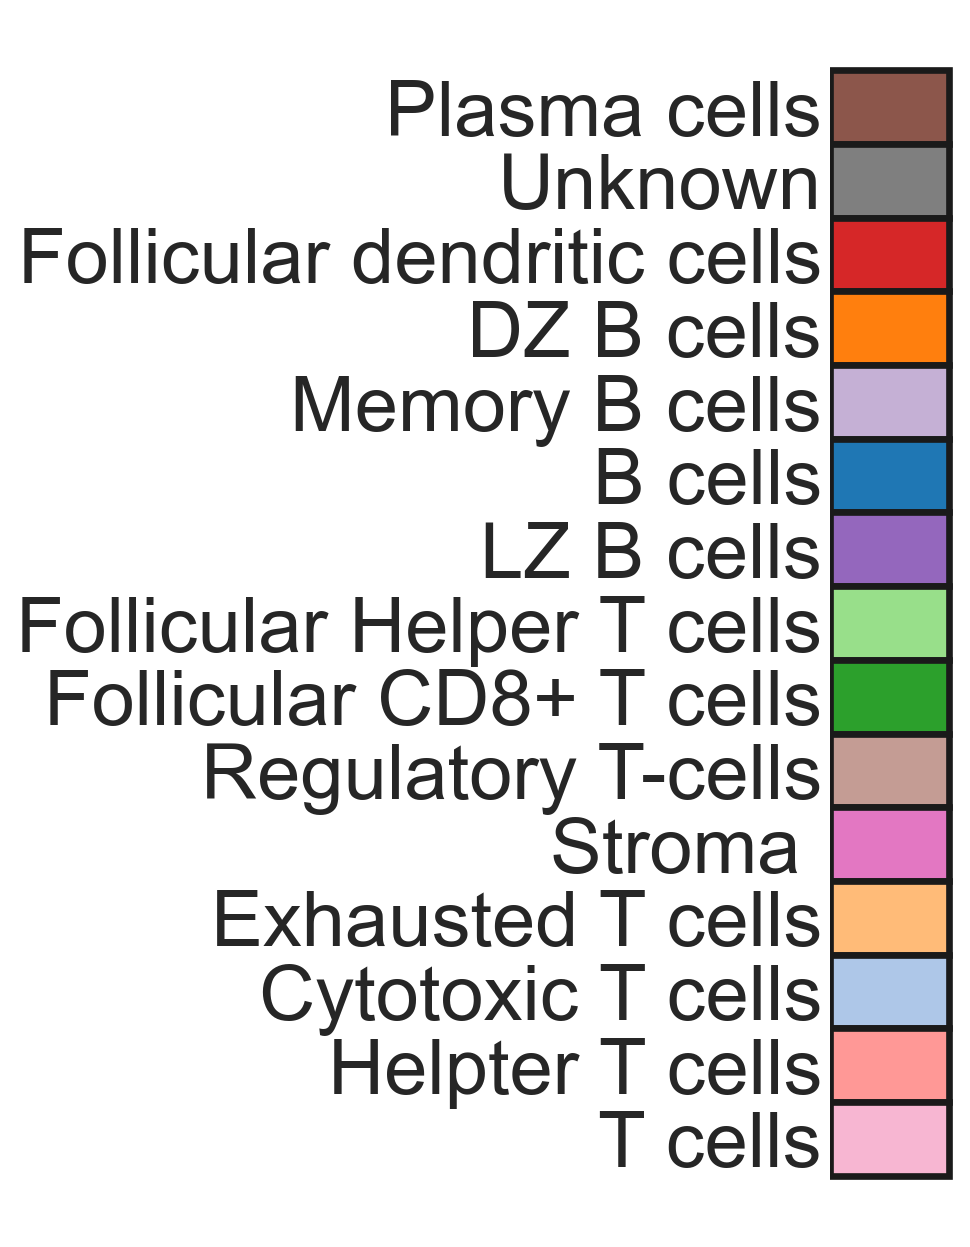

In [62]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,10))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


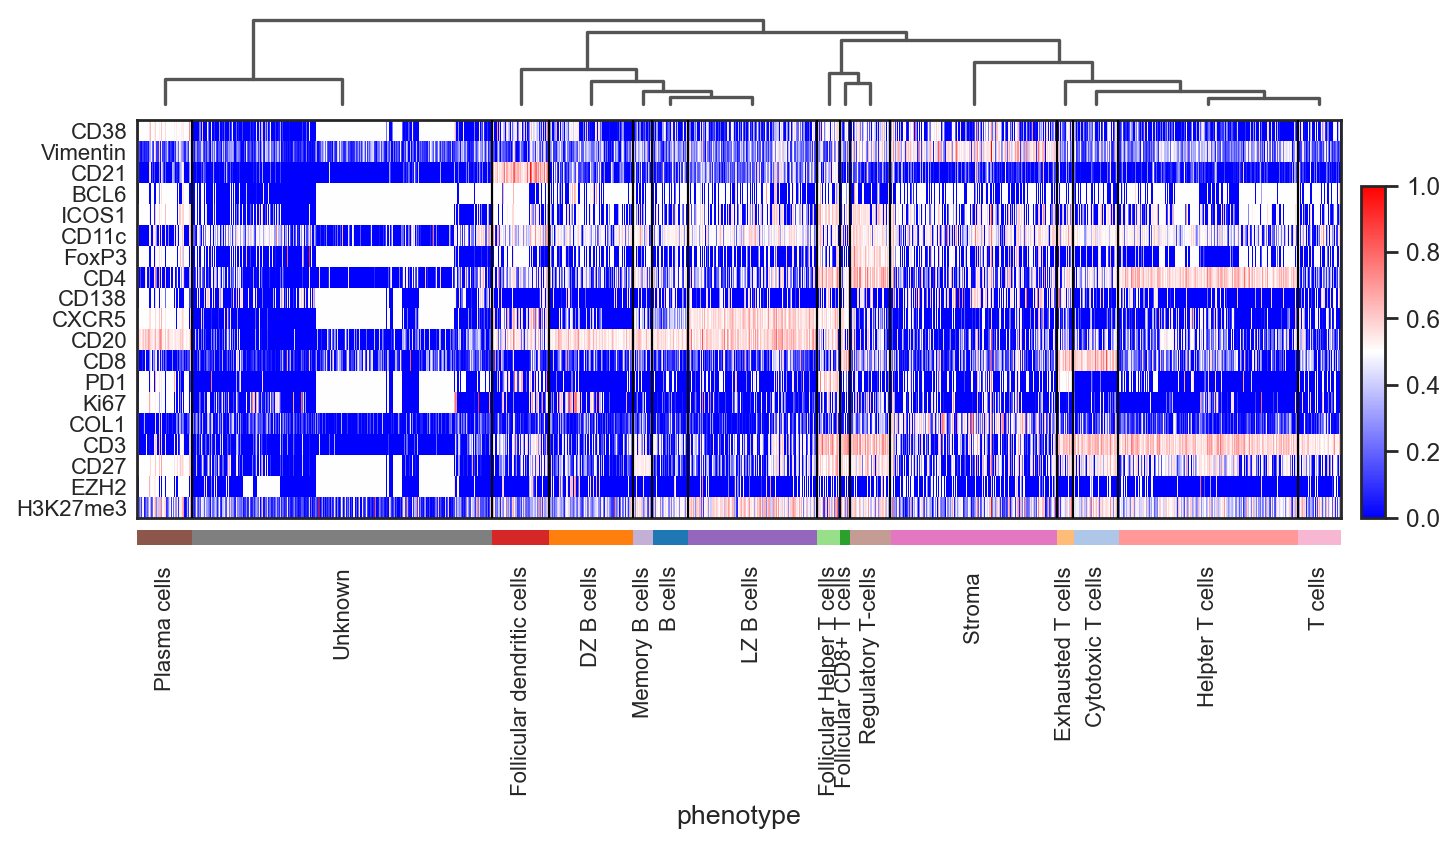

In [63]:
sc.pl.heatmap(adata, var_names= adata.var.index, groupby='phenotype', dendrogram=True, swap_axes=True, use_raw=False, cmap="bwr")